In [676]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from datetime import datetime
import imageio.v2 as imageio

In [677]:
#Configure TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

print(tf.__version__)

2.9.1


In [678]:
DATADIR = 'C://Users//mbrya//Desktop//planes'

image_size = 64 #Note, changing this does not change the model to work with a different image size, just used to quickly get the image size
latent_dim = 100

# load and prepare training images
X = []

# load real samples and normalize
for img in os.listdir(DATADIR):
    path = os.path.join(DATADIR, img)
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = (img - 127.5) / 127.5 #normalize to [-1, 1]
    X.append(img)

In [679]:
X = np.array(X, dtype='float32')
print(X.shape)

(9970, 64, 64, 3)


sample_img.shape=(64, 64, 3)


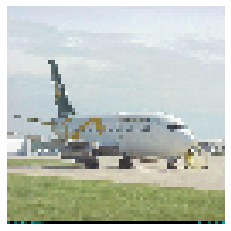

In [680]:
# show sample image
sample_img = X[0]
#scale to [0, 1] for display
sample_img = (sample_img + 1) / 2
print(f'{sample_img.shape=}')
plt.axis('off')
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.savefig('images/sample.png')
plt.show()

In [681]:
#seeds for progress images
num_generated_images = 4**2 #must be square to fit in grid
seeds = np.random.randn(num_generated_images, latent_dim).astype(np.float32)

In [682]:
def discriminator(input_shape=(image_size, image_size, 3)):
    # Initialize a Sequential model
    discriminator_model = Sequential()

    # Add a convolutional layer with 64 filters, 5x5 kernel size, stride of 2, and LeakyReLU activation
    discriminator_model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=0.2))

    # Add a convolutional layer with 128 filters, 5x5 kernel size, stride of 2, BatchNormalization, and LeakyReLU activation
    discriminator_model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=0.2))

    # Add a convolutional layer with 256 filters, 5x5 kernel size, stride of 2, BatchNormalization, and LeakyReLU activation
    discriminator_model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=0.2))

    # Add a convolutional layer with 512 filters, 5x5 kernel size, stride of 2, BatchNormalization, and LeakyReLU activation
    discriminator_model.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    discriminator_model.add(BatchNormalization())
    discriminator_model.add(LeakyReLU(alpha=0.2))

    # Flatten the output of the convolutional layers into a one-dimensional vector
    discriminator_model.add(Flatten())
    discriminator_model.add(Dropout(0.3))

    # Add a fully connected layer with 1 output and a sigmoid activation function
    discriminator_model.add(Dense(1, activation='sigmoid'))

    # # compile model with learning rate decay
    opt = Adam(learning_rate=ExponentialDecay(initial_learning_rate=0.0001, decay_steps=1000, decay_rate=0.9), beta_1=0.5)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Return the model
    return discriminator_model

In [683]:
d = discriminator()

In [684]:
d.summary()

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_126 (Conv2D)         (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_124 (Ba  (None, 32, 32, 64)       256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_197 (LeakyReLU)  (None, 32, 32, 64)       0         
                                                                 
 conv2d_127 (Conv2D)         (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_125 (Ba  (None, 16, 16, 128)      512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_198 (LeakyReLU)  (None, 16, 16, 128)    

In [685]:
def generator(latent_dim):
    # Create the generator model
    generator_model = Sequential()

    # Dense layer to map the noise vector to a higher-dimensional feature space
    generator_model.add(Dense(units=8 * 8 * 256, input_shape=(latent_dim,)))
    generator_model.add(LeakyReLU(alpha=0.2))
    generator_model.add(Reshape(target_shape=(8, 8, 256)))
    # Output shape: (batch_size, 8, 8, 256)

    # Transposed convolutional layers to upsample the noise vector into an image
    generator_model.add(Conv2DTranspose(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    generator_model.add(LeakyReLU(alpha=0.2))
    # Output shape: (batch_size, 16, 16, 64)

    generator_model.add(Conv2DTranspose(filters=32, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    generator_model.add(LeakyReLU(alpha=0.2))
    # Output shape: (batch_size, 32, 32, 32)

    # Final transposed convolutional layer to generate 64x64 color images with 3 channels (RGB)
    generator_model.add(Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    # Output shape: (batch_size, 64, 64, 3)

    generator_model.add(Conv2D(3, (5, 5), padding="same", activation="tanh"))

    return generator_model


In [686]:
g = generator(latent_dim)

In [687]:
g.summary()

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 16384)             1654784   
                                                                 
 leaky_re_lu_201 (LeakyReLU)  (None, 16384)            0         
                                                                 
 reshape_27 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_89 (Conv2D  (None, 16, 16, 64)       262208    
 Transpose)                                                      
                                                                 
 leaky_re_lu_202 (LeakyReLU)  (None, 16, 16, 64)       0         
                                                                 
 conv2d_transpose_90 (Conv2D  (None, 32, 32, 32)       32800     
 Transpose)                                          

In [688]:
def gan(gen, discrim):

    discrim.trainable = False

    model = Sequential()
    model.add(gen)
    model.add(discrim)

    #use learning rate decay
    opt = Adam(learning_rate=ExponentialDecay(initial_learning_rate=0.0003, decay_steps=1000, decay_rate=0.9), beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)

    return model

In [689]:
gan = gan(g, d)

In [690]:
gan.summary()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_82 (Sequential)  (None, 64, 64, 3)         1951559   
                                                                 
 sequential_81 (Sequential)  (None, 1)                 4318593   
                                                                 
Total params: 6,270,152
Trainable params: 1,951,559
Non-trainable params: 4,318,593
_________________________________________________________________


In [691]:
def generate_latent_points(lat_dim, n_samples):

    assert lat_dim > 0 and n_samples > 0

    x_input = np.random.randn(n_samples, lat_dim)

    return x_input

In [692]:
def generate_fake_samples(gen, lat_dim, n_samples, seeds=None):

    x_input = generate_latent_points(lat_dim, int(n_samples)) if seeds is None else seeds

    x_fake = gen.predict(x_input, verbose=0)

    return x_fake

In [693]:
def get_real_samples(n_samples):
    ix = np.random.randint(0, X.shape[0], int(n_samples))
    
    x_real = X[ix]
    x_real.reshape(n_samples, image_size, image_size, 3)
    
    return x_real

In [694]:
def generate_and_save_images(gen, epoch):

    #produces a square of n x n images
    n = int(np.sqrt(num_generated_images))

    x_fake = generate_fake_samples(gen, latent_dim, num_generated_images, seeds)

    x_fake = x_fake.reshape((n*n, image_size, image_size, 3))

    for im in range(n**2):
        #scale to [0,1]
        x_fake[im] = (x_fake[im] + 1) / 2.0
        plt.subplot(n, n, 1 + im)
        plt.axis('off')
        plt.imshow(np.clip(cv2.cvtColor(x_fake[im], cv2.COLOR_BGR2RGB), 0, 1))

    plt.suptitle(f'Epoch {epoch + 1}')

    plt.savefig(f'images/epoch_{epoch + 1}.png')

In [695]:
g_losses = []
d_losses = []
g_acc = []
d_acc = []

In [696]:
def test_accuracy(gen, discrim, n_tests=100):

    x_real = get_real_samples(n_tests)

    x_fake = generate_fake_samples(gen, latent_dim, n_tests)

    y_real = np.ones((int(n_tests), 1))

    y_fake = np.zeros((int(n_tests), 1))

    _, acc_real = discrim.evaluate(x_real, y_real, verbose=0)

    _, acc_fake = discrim.evaluate(x_fake, y_fake, verbose=0)

    print(f'Accuracy real: {acc_real * 100:.2f}% Accuracy fake: {acc_fake * 100:.2f}%')

    g_acc.append(acc_fake)
    d_acc.append(acc_real)

In [697]:
d_losses = []
g_losses = []

def train_gan(gen, discrim, gan_model, lat_dim, epochs=128, batch_size=64, label_smoothing=0.9):
    
    assert batch_size > 1 and epochs > 0
    
    for e in range(epochs):
        
        #batches
        for _ in range(int(len(X) / batch_size)):
            
            # Add noise to the real data
            x_real = get_real_samples(int(batch_size / 2))
            x_real = x_real + np.random.normal(0, 0.1, size=x_real.shape)
            
            # Generate fake data and add noise
            x_fake = generate_fake_samples(gen, lat_dim, int(batch_size / 2))
            x_fake = x_fake + np.random.normal(0, 0.1, size=x_fake.shape)
            
            # Concatenate real and fake data
            x = np.vstack((x_real, x_fake))
            y_real = np.ones((int(batch_size / 2), 1)) * label_smoothing
            y_fake = np.zeros((int(batch_size / 2), 1))
            y = np.vstack((y_real, y_fake))

            # Shuffle the concatenated arrays
            shuffle_indices = np.random.permutation(batch_size)
            x = x[shuffle_indices]
            y = y[shuffle_indices]
            
            # Train the discriminator
            d_loss, _ = discrim.train_on_batch(x, y)

            # Generate points in latent space
            x_gan = generate_latent_points(latent_dim, batch_size)

            # Label as real
            y_gan = np.ones((batch_size, 1))

            # Train the generator through the GAN model
            g_loss = gan_model.train_on_batch(x_gan, y_gan)

            d_losses.append(d_loss)
            g_losses.append(g_loss)
        
        # Save generated images every epoch
        generate_and_save_images(gen, e)

        print(f'Epoch: {e+1}\nDiscriminator Loss: {d_loss}, Generator Loss: {g_loss}')
        test_accuracy(gen, discrim)
        print()


Epoch: 1
Discriminator Loss: 0.2125580608844757, Generator Loss: 2.7730607986450195
Accuracy real: 0.00% Accuracy fake: 100.00%

Epoch: 2
Discriminator Loss: 0.2359052300453186, Generator Loss: 4.6971282958984375
Accuracy real: 43.00% Accuracy fake: 100.00%

Epoch: 3
Discriminator Loss: 0.24831192195415497, Generator Loss: 5.543266296386719
Accuracy real: 72.00% Accuracy fake: 100.00%

Epoch: 4
Discriminator Loss: 0.28044578433036804, Generator Loss: 2.987147092819214
Accuracy real: 100.00% Accuracy fake: 100.00%

Epoch: 5
Discriminator Loss: 0.2443006932735443, Generator Loss: 3.8669471740722656
Accuracy real: 100.00% Accuracy fake: 98.00%

Epoch: 6
Discriminator Loss: 0.217487633228302, Generator Loss: 4.12649393081665
Accuracy real: 99.00% Accuracy fake: 100.00%

Epoch: 7
Discriminator Loss: 0.20361213386058807, Generator Loss: 1.324761986732483
Accuracy real: 100.00% Accuracy fake: 65.00%

Epoch: 8
Discriminator Loss: 0.23025646805763245, Generator Loss: 0.4905969500541687
Accuracy

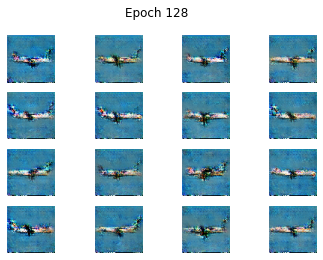

In [698]:
train_gan(g, d, gan, latent_dim)

In [699]:
#Save the models
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
#Make new directory for the models
os.mkdir(f'models/{timestamp}')
g.save(f'models/{timestamp}/generator.h5')
d.save(f'models/{timestamp}/discriminator.h5')
gan.save(f'models/{timestamp}/gan.h5')

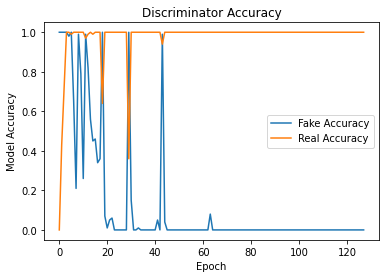

In [700]:
#Discriminator Accuracy
plt.plot(g_acc, label='Fake Accuracy')
plt.plot(d_acc, label='Real Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Model Accuracy")
plt.title('Discriminator Accuracy')
plt.legend()

plt.show()

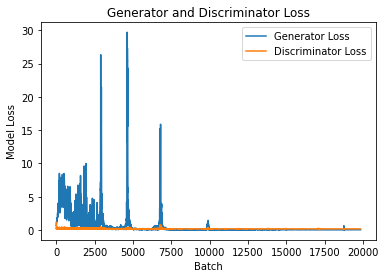

In [701]:
#Generator and Discriminator Loss
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')

plt.xlabel("Batch")
plt.ylabel("Model Loss")
plt.title('Generator and Discriminator Loss')
plt.legend()

plt.show()

## Sample Generated Images

<img src="images/epoch_112.png" alt="Generated Image"  width="600" />

In [713]:
#Make training gif

images = []
for i in range(1, 129):
    images.append(imageio.v2.imread(f'images/epoch_{i}.png'))
imageio.mimsave('images/training.gif', images)

## Model Training

<img src="images/training.gif" alt="Training Gif"  width="600" />

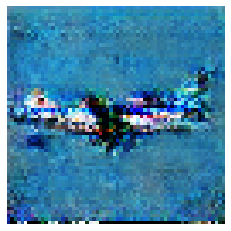

In [727]:
#Make sweep over latent space

#Remove all images in the directory
for file in os.listdir('images/latent_space'):
    os.remove(os.path.join('images/latent_space', file))

#Generate seed of all zeros
seed = np.zeros((1, 100))

num_images = 256

#Set index of seed to 0

#Sweep over latent space
for i in range(0, num_images):
    x_fake = generate_fake_samples(g, latent_dim, 1, seed)
    x_fake = (x_fake + 1) / 2.0
    plt.imshow(np.clip(cv2.cvtColor(x_fake[0], cv2.COLOR_BGR2RGB), 0, 1))
    plt.axis('off')
    plt.savefig(f'images/latent_space/{i}.png')
    #Randomly step all values in the seed
    seed = seed + np.random.normal(0, 0.1, size=seed.shape)

In [728]:
#Make latent space gif
images = []
for i in range(0, num_images):
    images.append(imageio.v2.imread(f'images/latent_space/{i}.png'))
imageio.mimsave('images/latent_space.gif', images, fps=60)

## Latent Space Sweep
<img src="images/latent_space.gif" alt="Latent space sweep" width="400">